## Распознавание карт лояльности на Keras

In [0]:
# Сначала сделаем загрузку данных:
! shred -u setup_google_colab.py
! wget https://raw.githubusercontent.com/DmitriiDenisov/intro_dl_seminars/master/setup_colab.py -O setup_google_colab.py
from setup_google_colab import setup_week2
setup_week2()

 В этом ноутбуке будем работать с датасетом карт лояльности. 
 Задача: по фотографии карточки определить к какому бренду она относится

В данном ноутбуке мы разберём пример практической задачи по распазнованию бренда карты лояльности по её фотографии.

In [0]:
from numpy.random import choice
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [0]:
PROJECT_PATH = os.getcwd()
PATH_TRAIN = os.path.join(PROJECT_PATH, 'data', 'TEMP_CODE', 'train')

In [0]:
all_files = []
for root, dirs, files in os.walk(PATH_TRAIN):
    for f in files:
        all_files.append( os.path.abspath(os.path.join(root, f)).replace("\\","/"))

Ниже приведён пример данных, на которых мы будем обучаться:

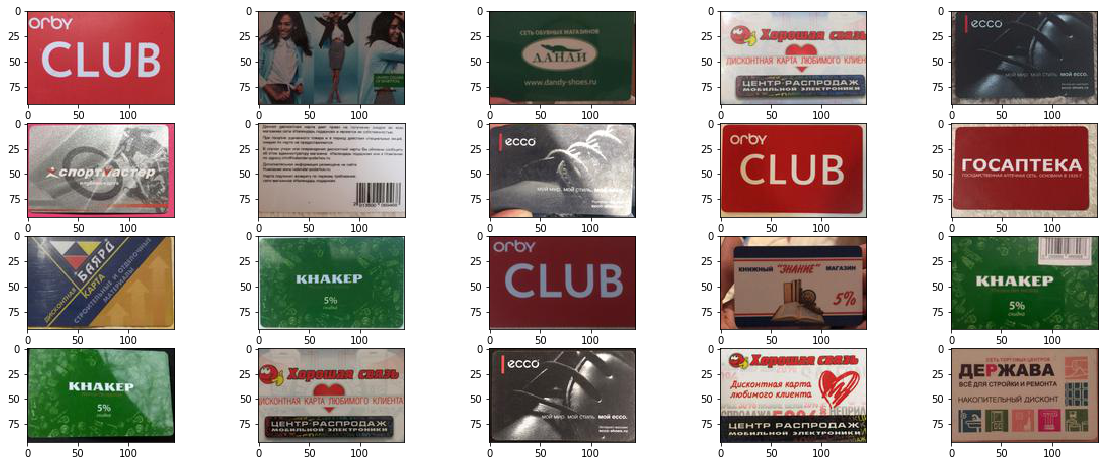

In [0]:
SIZE = 20 # число случайно выбранных карточек из обучающего датасета
selected = choice(all_files, size=SIZE)

images = []
for img_path in selected:
    #print(img_path)
    images.append(mpimg.imread(img_path))
#print(images)

plt.figure(figsize=(20,10))
columns = 5
for i, image_ in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image_)

Всего в выборке 18 классов, в каждом примерно по 200 фотографий, итого примерно 3600 фотографий в обучающей выборке. В валидационной выборке те же 18 классов, для ккаждого примерно по 30 фотографий, итого 540 фотографий в валидационной выборке

In [0]:
import os
import sys
import keras
from keras.models import Sequential
from keras.preprocessing import image
from keras.layers.core import Activation, Reshape, Dense, Flatten
from keras.layers import Conv2D, MaxPool2D
from keras.models import Model
from keras import optimizers
from keras.callbacks import ModelCheckpoint
#from keras.layers import DepthwiseConv2D
#from keras.applications.mobilenet import relu6
from keras.utils.generic_utils import CustomObjectScope
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
PROJECT_PATH = os.getcwd()
sys.path.append(PROJECT_PATH)

def count_folders(path):
    return len(glob.glob(os.path.join(path,'*')))

def get_barcode_class(path):
    return os.path.basename(path)

Using TensorFlow backend.


### Объявления:

Вспомогательные объявления, например, число классов, размер батча, путь к данным и т.д.

In [0]:
args = {'batch_size': 16, 'data_path': os.path.join(PROJECT_PATH, 'data', 'TEMP_CODE'), 
        'previous_model': ''}

""" Define barcode class and underlying classes number from file structure """
NUM_CLASSES = count_folders(os.path.join(args['data_path'], 'train'))
BARCODE = get_barcode_class(args['data_path'])
SUPPORT_FILES_PATH = os.path.join(PROJECT_PATH, 'resource', BARCODE, 'support_files')
""" Define data path and output path  """
DATA_PATH = args['data_path']

""" Check if previously trained model is used """
if args['previous_model'] == '':
    TRAIN_FROM_ZERO = True
else:
    TRAIN_FROM_ZERO = False

### Модель:

Ниже следует блок с объявлением модели. Вы можете: 

1) Собрать кастомную сеть

2) Загрузить существующую сеть. Например, для импорта VGG16: ```from keras.applications import vgg16```, затем ```model = vgg16.VGG16(weights='imagenet')```. У модели можно зафиксировать веса первых n слоёв и обучать все оставшиеся

3) Загрузить модель из папки models и дообучить её. При первом запуске папка models пустая, в неё будут автоматически сохраняться модели при обучении в конце каждой эпохи

In [0]:
if TRAIN_FROM_ZERO:
    
    ###
    # <YOUR CODE GOES HERE>
    # В случае, если вы захотите загружать существующую модель из Кераса, то для того, чтобы поменять последние слои
    # вам понадобятся следующие команды:
    #model.layers.pop()
    #model.layers[-1].output
    #Model(input=model.inputs, output=x)
    
    model_name = model.name
else:
    #with CustomObjectScope({'relu6': keras.layers.ReLU(6.), 'DepthwiseConv2D': DepthwiseConv2D}):
    path = os.path.join(PROJECT_PATH, 'models', BARCODE, args['previous_model'] + '.h5')
    model = keras.models.load_model(path)
    model_name = model.name
        
TRAINABLE_LAYERS = True
for layer in model.layers: 
    layer.trainable = TRAIN_FROM_ZERO
model.summary()

In [0]:
OUTPUT_PATH = os.path.join(PROJECT_PATH, 'models', BARCODE)
#os.makedirs(OUTPUT_PATH)

### Объявления генераторов данных:

Ниже объявим генераторы данных.
В Керасе реализован класс ImageDataGenerator, который определяет конфигурацию для подготовленных к обучению изображений, а также отвечает за аугментацию данных.
Аугументация данных происходит на лету во время обучения раз в эпоху, поэтому данные почти никогда не будут повторяться - это хорошо. И точка переобучения будет дальше - можно тренировать больше эпох.

Краткий туторила по генераторам данных из Keras: 
https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d

Параметры объекта ```keras.preprocessing.image.ImageDataGenerator```: https://keras.io/preprocessing/image/

In [0]:
""" Data generators initialization: for train and validation sets """
train_datagen = image.ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=False,
    zca_whitening=False)
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(args['data_path'], 'train'),
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=args['batch_size'],
    class_mode="categorical",
    shuffle=True,
    seed=42
)

valid_datagen = image.ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=0,
    zca_whitening=False)

valid_generator = valid_datagen.flow_from_directory(
    directory=os.path.join(args['data_path'], 'val'),
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=args['batch_size'],
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 4520 images belonging to 18 classes.
Found 2256 images belonging to 18 classes.


Делаем compile и запускаем обучение:

In [0]:
""" Set train parameters for choosen model """
# Можете расккоментировать другие оптимизаторы:
#sgd = optimizers.SGD(lr=0.05, decay=1e-6, momentum=0.9, nesterov=True)
optimizer = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
#optimize = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)

model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

STEP_SIZE_TRAIN = (train_generator.n // train_generator.batch_size)
STEP_SIZE_VALID = (valid_generator.n // valid_generator.batch_size)

### Обучение модели:

В модель передаём: генератор данных (он сам автоматически генерирует X и y), валидационную выборку (тоже посредством генератора), число эпох, коллбеки и verbose

In [0]:
""" Training """
history = model.fit_generator(generator=train_generator,
                                  steps_per_epoch=STEP_SIZE_TRAIN,
                                  validation_data=valid_generator,
                                  #validation_steps=STEP_SIZE_VALID,
                                  epochs=4,
                                  verbose=1
                                  )